<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/LC_4_updated_15_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 18.7 MB/s eta 0:00:00

LOADING AND PREPROCESSING LENDING CLUB (LC_50K) DATASET
Dataset shape: (50000, 10)
Target distribution: {0: 48000, 1: 2000}
Default rate: 4.00%
Imbalance ratio: 24.00:1

Categorical columns (5): ['experience_c', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state']
Numeric columns (4): ['revenue', 'dti_n', 'loan_amnt', 'fico_n']...

Number of processed features: 82
First 10 feature names: ['cat__experience_c_1' 'cat__emp_length_10+ y

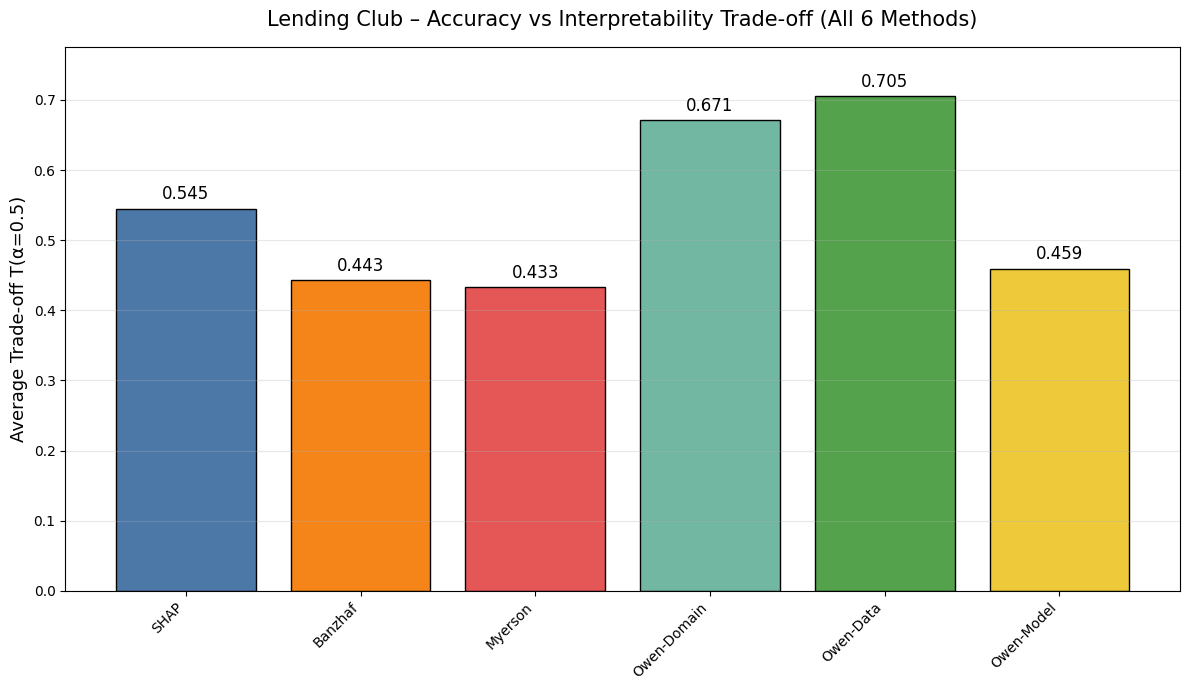

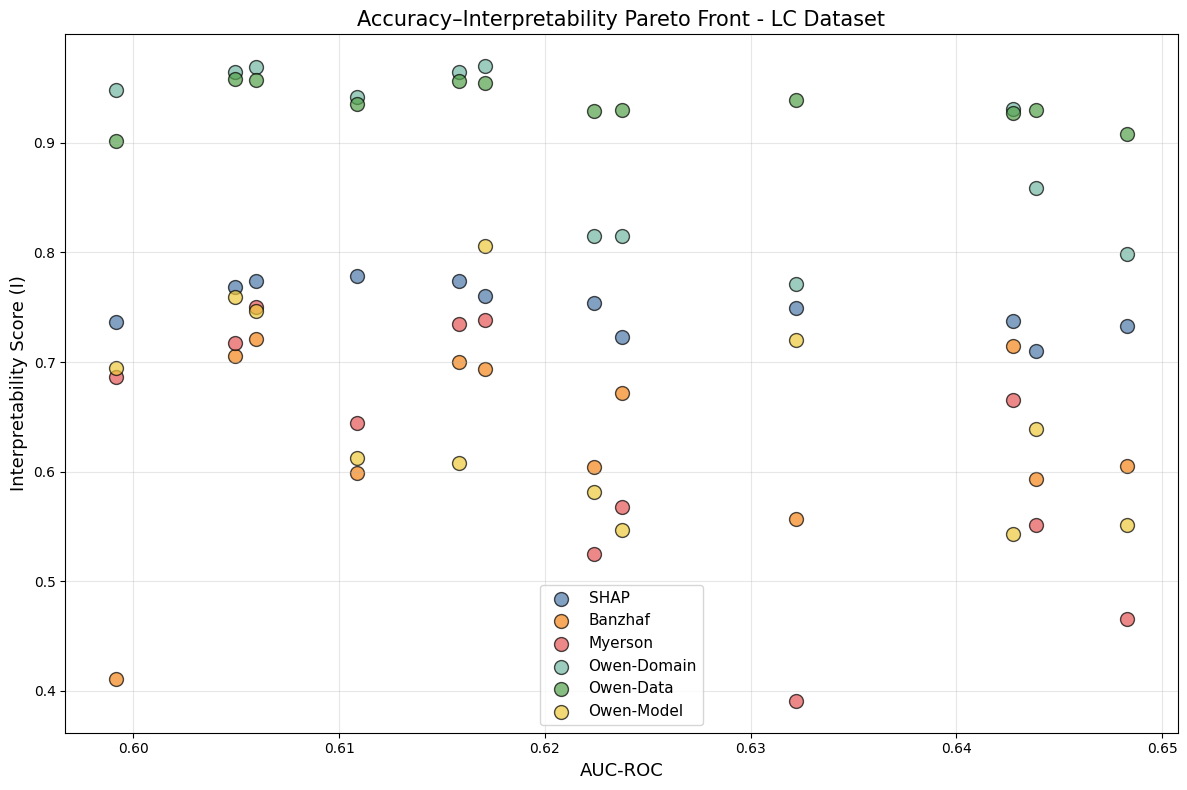

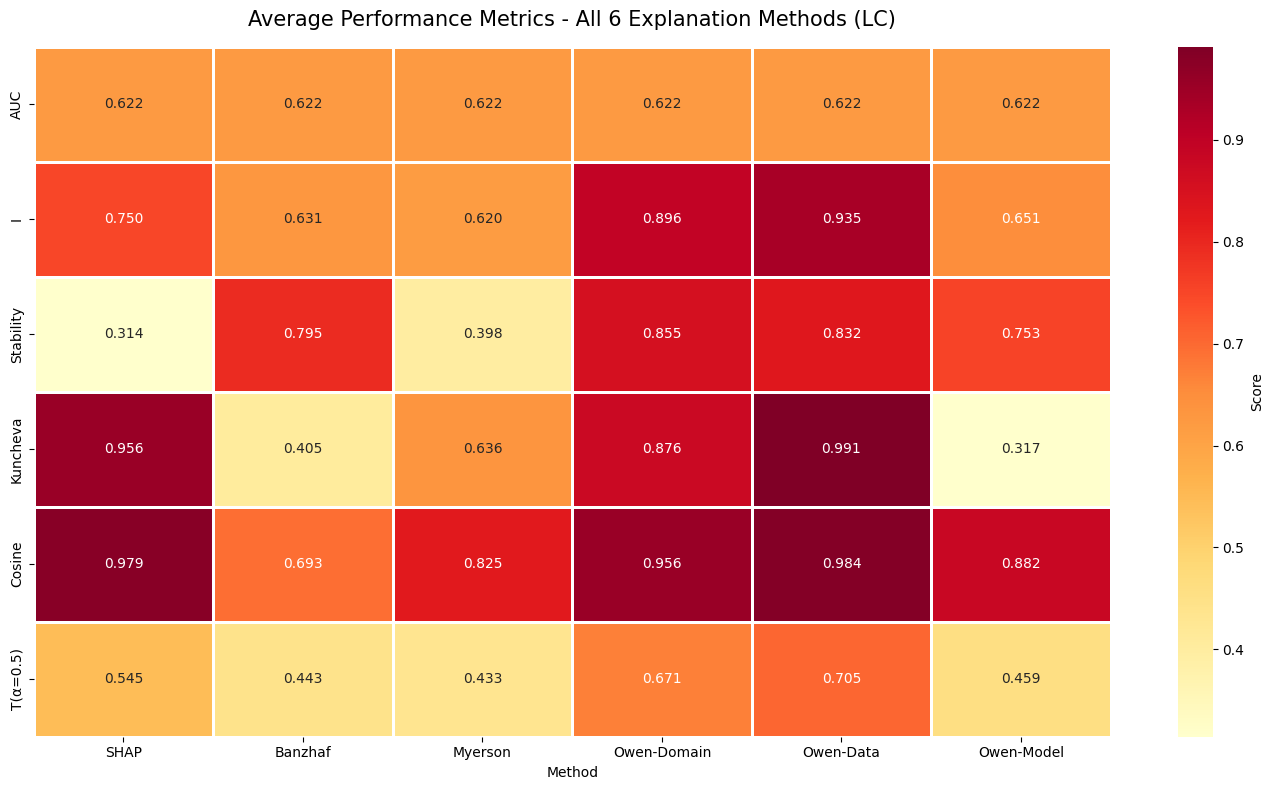

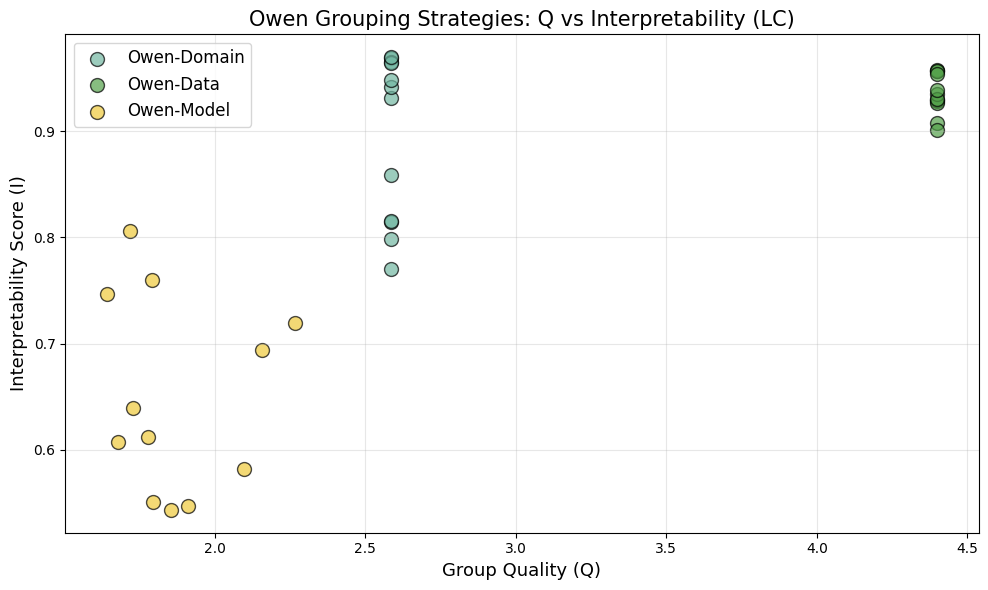


STATISTICAL ANALYSIS - ALL 6 METHODS (LC)

Friedman Test for T(α=0.5):
Methods compared: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']
Friedman χ² = 50.6190, p = 0.000000
✓ SIGNIFICANT differences between methods

Nemenyi Post-Hoc Test (p-values):
        0       1       2       3       4       5
0  1.0000  0.0927  0.0927  0.2460  0.3632  0.2460
1  0.0927  1.0000  1.0000  0.0000  0.0001  0.9980
2  0.0927  1.0000  1.0000  0.0000  0.0001  0.9980
3  0.2460  0.0000  0.0000  1.0000  0.9999  0.0002
4  0.3632  0.0001  0.0001  0.9999  1.0000  0.0005
5  0.2460  0.9980  0.9980  0.0002  0.0005  1.0000

Pairwise Wilcoxon Tests for T(α=0.5):
SHAP vs Banzhaf: p=0.0005 (means: 0.545 vs 0.443) ✓
SHAP vs Myerson: p=0.0005 (means: 0.545 vs 0.433) ✓
SHAP vs Owen-Domain: p=0.0005 (means: 0.545 vs 0.671) ✓
SHAP vs Owen-Data: p=0.0005 (means: 0.545 vs 0.705) ✓
SHAP vs Owen-Model: p=0.0049 (means: 0.545 vs 0.459) ✓
Owen-Domain vs Owen-Data: p=0.4238 (means: 0.671 vs 0.705) ✗
Owen-

In [1]:
# ============================================================
# LENDING CLUB (LC_50K) - UNIFIED GAME THEORY EXPLAINABILITY
# ============================================================

!pip install xgboost shap imbalanced-learn lightgbm scikit-posthocs seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import networkx as nx
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cosine

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# ============================================================
# 1. LOAD AND PREPROCESS LENDING CLUB DATASET
# ============================================================
print("\n" + "="*80)
print("LOADING AND PREPROCESSING LENDING CLUB (LC_50K) DATASET")
print("="*80)

# Assumes LC_50K.csv is in the working directory
df = pd.read_csv('LC_50K.csv')

# Ensure target column is named 'target'
if 'Default' in df.columns:
    df = df.rename(columns={'Default': 'target'})

# Drop obvious ID / leakage columns if present
cols_to_drop = ['id', 'issue_d', 'zip_code', 'title', 'desc']
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_to_drop)

# Handle missing values (simple, consistent with earlier LC script)
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

X = df.drop('target', axis=1)
y = df['target'].astype(int)

print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Default rate: {(y.mean() * 100):.2f}%")
print(f"Imbalance ratio: {sum(y==0)/sum(y==1):.2f}:1")

# Identify categorical and numeric columns (as in previous LC code)
cat_cols = ['experience_c', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state']
cat_cols = [c for c in cat_cols if c in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {num_cols[:10]}...")

# Create preprocessing pipeline
cat_categories = [sorted(X[col].dropna().unique().tolist()) for col in cat_cols]
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore',
                          sparse_output=False, categories=cat_categories), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# Fit preprocessor
X_processed = preprocessor.fit_transform(X)
d = X_processed.shape[1]
fnames = preprocessor.get_feature_names_out()
print(f"\nNumber of processed features: {d}")
print(f"First 10 feature names: {fnames[:10]}")

# ============================================================
# 2. MODELS & SAMPLING STRATEGIES (UNIFIED WITH TAIWAN/GERMAN)
# ============================================================
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42,
                             eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42,
                              verbose=-1, n_jobs=-1)
}

resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'CostSensitive': 'cost'
}

# Compute class weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}
print(f"\nClass weights: {class_weight_dict}")

# ============================================================
# 3. EXPLANATION METHODS (ALL 6 METHODS)
# ============================================================
def get_shap_reliable(pipe, X_test):
    """Get SHAP values for a trained pipeline"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv, list):
            return sv[1]  # binary
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"SHAP failed: {e}. Using permutation importance fallback...")
        from sklearn.inspection import permutation_importance
        res = permutation_importance(clf, X_proc, pipe.predict(X_proc),
                                     n_repeats=3, random_state=42)
        return np.tile(res.importances_mean, (X_proc.shape[0], 1))

def compute_banzhaf(pipe, X_test, n_samples=5, max_instances=5):
    """Compute Banzhaf values"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                coal = np.random.binomial(1, 0.5, n_feat)
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]

                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]
                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

def build_feature_graph(preprocessor, X, threshold=0.25):
    """Build feature graph for Myerson"""
    X_proc = preprocessor.transform(X)
    corr = np.corrcoef(X_proc.T)
    G = nx.Graph()
    d_graph = corr.shape[0]
    G.add_nodes_from(range(d_graph))
    for i in range(d_graph):
        for j in range(i+1, d_graph):
            if abs(corr[i, j]) >= threshold:
                G.add_edge(i, j, weight=corr[i, j])
    return G, corr

def compute_myerson(pipe, X_test, G, alpha=0.5):
    """Compute Myerson values using feature graph"""
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)
    d_local = len(shap_mean)
    phi = np.zeros(d_local)

    for i in range(d_local):
        neighbors = list(G.neighbors(i))
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean

    return np.tile(phi, (min(50, len(X_test)), 1))

# ============================================================
# 3B. OWEN GROUPING STRATEGIES (IMPROVED LC DOMAIN GROUPS)
# ============================================================
def build_domain_groups_lc(fnames):
    """
    Improved LC domain groups based on financial semantics.
    We use substrings that typically appear in LC_50K engineered names.
    """
    groups = {
        "Domain_EmploymentIncome": [],
        "Domain_LoanTerms": [],
        "Domain_CreditHistory": [],
        "Domain_Delinquency": [],
        "Domain_Utilization": [],
        "Domain_Purpose": [],
        "Domain_AssetsCollateral": [],
        "Domain_Location": []
    }

    for i, name in enumerate(fnames):
        lname = name.lower()

        # Employment & income / risk profile
        if any(k in lname for k in [
            "experience_c", "emp_length", "annual_inc", "revenue", "dti", "dti_n", "fico"
        ]):
            groups["Domain_EmploymentIncome"].append(i)

        # Loan terms & contract characteristics
        if any(k in lname for k in [
            "loan_amnt", "term", "installment", "int_rate"
        ]):
            groups["Domain_LoanTerms"].append(i)

        # Credit history & account structure
        if any(k in lname for k in [
            "open_acc", "total_acc", "revol_bal", "revol_util", "inq_last", "inq_last_6mths"
        ]):
            groups["Domain_CreditHistory"].append(i)

        # Delinquency / public records
        if any(k in lname for k in [
            "delinq", "pub_rec", "collections", "chargeoff"
        ]):
            groups["Domain_Delinquency"].append(i)

        # Utilization / revolving behavior (extra emphasis)
        if any(k in lname for k in [
            "revol_util", "revol_bal", "utilization"
        ]):
            groups["Domain_Utilization"].append(i)

        # Purpose of loan
        if "purpose" in lname:
            groups["Domain_Purpose"].append(i)

        # Assets / collateral (home ownership etc.)
        if "home_ownership" in lname or "home_ownership_n" in lname:
            groups["Domain_AssetsCollateral"].append(i)

        # Location
        if "addr_state" in lname or "state" in lname:
            groups["Domain_Location"].append(i)

    # Remove empty groups
    return {g: v for g, v in groups.items() if len(v) > 0}

def build_data_groups(X_proc, n_groups=6):
    """Build data-driven groups using correlation clustering"""
    try:
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)

        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Data_Cluster_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        return {"Data_Default": list(range(n_features))}, np.eye(n_features)

def build_model_groups(shap_vals, n_groups=6):
    """Build model-driven groups using SHAP correlation"""
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)

        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()

        if shap_vals.shape[0] < shap_vals.shape[1]:
            shap_vals = shap_vals.T

        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            return {"Model_Default": list(range(n_features))}, np.eye(n_features)

        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)

        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Model_Group_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        return {"Model_Default": list(range(n_features))}, np.eye(n_features)

def owen_from_shap(phi, groups):
    """Redistribute SHAP values using Owen grouping"""
    d_local = len(phi)
    out = np.zeros(d_local)

    for _, feats in groups.items():
        if len(feats) == 0:
            continue

        valid_feats = [f for f in feats if f < d_local]
        if not valid_feats:
            continue

        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)

        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per

    return out

def compute_Q(groups, dep):
    """Compute group quality metric Q (within / across)"""
    try:
        d_local = dep.shape[0]
        group_id = np.full(d_local, -1)

        for gid, (_, feats) in enumerate(groups.items()):
            for f in feats:
                if f < d_local:
                    group_id[f] = gid

        within, across = [], []
        for i in range(d_local):
            for j in range(i+1, d_local):
                if group_id[i] == group_id[j] and group_id[i] != -1:
                    within.append(dep[i, j])
                elif group_id[i] != -1 and group_id[j] != -1:
                    across.append(dep[i, j])

        if len(within) == 0 or len(across) == 0:
            return np.nan

        within_mean = np.mean(within)
        across_mean = np.mean(across)

        if across_mean == 0:
            return np.nan

        return float(within_mean / across_mean)
    except:
        return np.nan

# ============================================================
# 4. METRICS (CV, KUNCHEVA, COSINE, I, T)
# ============================================================
def stability_cv(expl_list):
    """Compute coefficient of variation stability metric"""
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0

def kuncheva_index(expl_list, k=5):
    """Compute Kuncheva index for feature consistency"""
    if len(expl_list) < 2:
        return 0.0

    sets = []
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())

    if len(sets) < 2:
        return 0.0

    ki_values = []
    for i in range(len(sets)):
        for j in range(i+1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d) / (k - (k**2)/d)
            ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)

    return float(np.mean(ki_values)) if ki_values else 0.0

def cosine_directional_consistency(expl_list):
    """Compute cosine directional consistency"""
    if len(expl_list) < 2:
        return 0.0

    mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]
    K = len(mean_vecs)
    cos_sims = []

    for p in range(K):
        for s in range(p+1, K):
            v_p = mean_vecs[p]
            v_s = mean_vecs[s]
            cos_val = 1 - cosine(v_p, v_s)
            cos_sims.append(cos_val)

    if not cos_sims:
        return 0.0
    return np.mean(cos_sims)

def interpretability_score(cv, kuncheva, cosine_score, beta=1/3):
    """Compute overall interpretability score"""
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_score

def normalize(s):
    """Normalize a series to [0,1]"""
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    """Compute trade-off metric between AUC and interpretability"""
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

# ============================================================
# 5. UNIFIED EXPERIMENT LOOP (ALL 6 METHODS)
# ============================================================
print("\n" + "="*80)
print("STARTING UNIFIED EXPERIMENT - ALL 6 EXPLANATION METHODS (LC)")
print("="*80)

# Build feature graph for Myerson
print("\nBuilding feature graph for Myerson value...")
X_proc_full = preprocessor.transform(X)
corr_full = np.corrcoef(X_proc_full.T)
G_myerson = nx.Graph()
d_graph = corr_full.shape[0]
G_myerson.add_nodes_from(range(d_graph))
for i in range(d_graph):
    for j in range(i+1, d_graph):
        if abs(corr_full[i, j]) >= 0.25:
            G_myerson.add_edge(i, j, weight=corr_full[i, j])
print(f"Graph built with {G_myerson.number_of_nodes()} nodes and {G_myerson.number_of_edges()} edges")

# Setup cross-validation (4 folds like LC/Taiwan)
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
all_records = []

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\n{'='*60}")
        print(f"Processing: {mname} + {sname}")
        print(f"{'='*60}")

        aucs = []
        shap_runs, banzhaf_runs, myerson_runs = [], [], []
        owen_dom_runs, owen_data_runs, owen_model_runs = [], [], []
        Q_dom_list, Q_data_list, Q_model_list = [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            # Train model once per fold
            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0] if 0 in class_weight_dict else 1
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)

            # Compute AUC
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f" Fold {fold} | {mname}+{sname:15} → AUC: {auc:.4f}")

            # Sample instances for explanations
            X_sample = X_te.sample(n=min(50, len(X_te)), random_state=42)

            # 1. SHAP
            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                shap_runs.append(shap_vals)
            except Exception as e:
                print(f"  SHAP failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                shap_runs.append(np.zeros((len(X_sample), n_features)))
                shap_vals = None

            # 2. Banzhaf
            try:
                banzhaf_vals = compute_banzhaf(pipe, X_sample, n_samples=3, max_instances=3)
                banzhaf_runs.append(banzhaf_vals)
            except Exception as e:
                print(f"  Banzhaf failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                banzhaf_runs.append(np.zeros((min(3, len(X_sample)), n_features)))

            # 3. Myerson
            try:
                if shap_vals is not None:
                    myerson_vals = compute_myerson(pipe, X_sample, G_myerson)
                else:
                    myerson_vals = np.zeros((min(50, len(X_sample)), d))
                myerson_runs.append(myerson_vals)
            except Exception as e:
                print(f"  Myerson failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                myerson_runs.append(np.zeros((min(50, len(X_sample)), n_features)))

            # 4. Owen-Domain (improved LC domain groups)
            try:
                dom_groups = build_domain_groups_lc(fnames)
                if shap_vals is not None:
                    phi = np.mean(shap_vals, axis=0)
                    owen_dom = np.tile(owen_from_shap(phi, dom_groups), (len(X_sample), 1))
                else:
                    owen_dom = np.zeros((len(X_sample), d))
                owen_dom_runs.append(owen_dom)

                # Q for domain groups
                X_tr_proc = preprocessor.transform(X_tr)
                corr_tr = np.abs(np.corrcoef(X_tr_proc.T))
                corr_tr = np.nan_to_num(corr_tr, nan=0.0)
                Q_dom_list.append(compute_Q(dom_groups, corr_tr))
            except Exception as e:
                print(f"  Owen-Domain failed: {e}")
                owen_dom_runs.append(np.zeros((len(X_sample), d)))
                Q_dom_list.append(np.nan)

            # 5. Owen-Data
            try:
                X_tr_proc = preprocessor.transform(X_tr)
                data_groups, dep_data = build_data_groups(X_tr_proc, n_groups=5)
                if shap_vals is not None:
                    phi = np.mean(shap_vals, axis=0)
                    owen_data = np.tile(owen_from_shap(phi, data_groups), (len(X_sample), 1))
                else:
                    owen_data = np.zeros((len(X_sample), d))
                owen_data_runs.append(owen_data)
                Q_data_list.append(compute_Q(data_groups, dep_data))
            except Exception as e:
                print(f"  Owen-Data failed: {e}")
                owen_data_runs.append(np.zeros((len(X_sample), d)))
                Q_data_list.append(np.nan)

            # 6. Owen-Model
            try:
                if shap_vals is not None:
                    bg_sample = X_tr.sample(n=min(100, len(X_tr)), random_state=42)
                    shap_bg = get_shap_reliable(pipe, bg_sample)
                    model_groups, dep_mod = build_model_groups(shap_bg, n_groups=5)
                    phi = np.mean(shap_vals, axis=0)
                    owen_model = np.tile(owen_from_shap(phi, model_groups), (len(X_sample), 1))
                else:
                    owen_model = np.zeros((len(X_sample), d))
                    model_groups, dep_mod = {"Model_Default": list(range(d))}, np.eye(d)
                owen_model_runs.append(owen_model)
                Q_model_list.append(compute_Q(model_groups, dep_mod))
            except Exception as e:
                print(f"  Owen-Model failed: {e}")
                owen_model_runs.append(np.zeros((len(X_sample), d)))
                Q_model_list.append(np.nan)

        # Mean AUC for this model-sampler
        auc_mean = np.mean(aucs)

        # Metrics per explanation method
        explanation_methods = [
            ('SHAP', shap_runs),
            ('Banzhaf', banzhaf_runs),
            ('Myerson', myerson_runs),
            ('Owen-Domain', owen_dom_runs),
            ('Owen-Data', owen_data_runs),
            ('Owen-Model', owen_model_runs)
        ]

        Q_values = {
            'Owen-Domain': np.nanmean(Q_dom_list) if Q_dom_list else np.nan,
            'Owen-Data': np.nanmean(Q_data_list) if Q_data_list else np.nan,
            'Owen-Model': np.nanmean(Q_model_list) if Q_model_list else np.nan
        }

        for method_name, runs in explanation_methods:
            cv_val = stability_cv(runs)
            kun_val = kuncheva_index(runs, k=5)
            cos_val = cosine_directional_consistency(runs)
            I_val = interpretability_score(cv_val, kun_val, cos_val)

            record = {
                'Dataset': 'LC',
                'Model': mname,
                'Sampler': sname,
                'Method': method_name,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kun_val,
                'Cosine': cos_val,
                'I': I_val,
                'Q': Q_values.get(method_name, np.nan)
            }
            all_records.append(record)

# ============================================================
# 6. PROCESS AND SAVE RESULTS
# ============================================================
if all_records:
    metrics = pd.DataFrame(all_records)
    metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

    print("\n" + "="*80)
    print("COMPLETE RESULTS - ALL 6 EXPLANATION METHODS (LC)")
    print("="*80)
    print(metrics.round(4).to_string(index=False))

    metrics.to_csv('lc_unified_results.csv', index=False)
    print("\n✓ Results saved to: lc_unified_results.csv")

# ============================================================
# 7. VISUALIZATIONS (UNIFIED STYLE)
# ============================================================
if not metrics.empty:
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)

    colors = {
        'SHAP': '#4C78A8',
        'Banzhaf': '#F58518',
        'Myerson': '#E45756',
        'Owen-Domain': '#72B7A2',
        'Owen-Data': '#54A24B',
        'Owen-Model': '#EECA3B'
    }

    method_order = ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']

    # 1. Average Trade-off by Method
    plt.figure(figsize=(12, 7))
    method_avg = metrics.groupby('Method')['T(α=0.5)'].mean().reindex(method_order)
    bars = plt.bar(method_avg.index, method_avg.values,
                   color=[colors[m] for m in method_avg.index], edgecolor='black')
    plt.bar_label(bars, fmt='%.3f', fontsize=12, padding=4)
    plt.ylabel("Average Trade-off T(α=0.5)", fontsize=13)
    plt.title("Lending Club – Accuracy vs Interpretability Trade-off (All 6 Methods)",
              fontsize=15, pad=15)
    plt.ylim(0, method_avg.max() * 1.1)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('lc_all_methods_tradeoff.png', dpi=300)
    plt.show()

    # 2. Pareto Front: AUC vs I
    plt.figure(figsize=(12, 8))
    for method in method_order:
        if method in metrics['Method'].unique():
            sub = metrics[metrics['Method'] == method]
            plt.scatter(sub['AUC'], sub['I'], s=100, label=method,
                        color=colors[method], alpha=0.7, edgecolors='black')
    plt.xlabel("AUC-ROC", fontsize=13)
    plt.ylabel("Interpretability Score (I)", fontsize=13)
    plt.title("Accuracy–Interpretability Pareto Front - LC Dataset", fontsize=15)
    plt.legend(fontsize=11, loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('lc_all_methods_pareto.png', dpi=300)
    plt.show()

    # 3. Heatmap of average metrics
    plt.figure(figsize=(14, 8))
    heatmap_data = metrics.groupby('Method').agg({
        'AUC': 'mean',
        'I': 'mean',
        'Stability': 'mean',
        'Kuncheva': 'mean',
        'Cosine': 'mean',
        'T(α=0.5)': 'mean'
    }).reindex(method_order).T

    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
                linewidths=1, linecolor='white', cbar_kws={'label': 'Score'})
    plt.title("Average Performance Metrics - All 6 Explanation Methods (LC)", fontsize=15, pad=15)
    plt.tight_layout()
    plt.savefig('lc_all_methods_heatmap.png', dpi=300)
    plt.show()

    # 4. Owen Grouping Comparison (Q vs I)
    owen_methods = ['Owen-Domain', 'Owen-Data', 'Owen-Model']
    if any(m in metrics['Method'].unique() for m in owen_methods):
        plt.figure(figsize=(10, 6))
        owen_data_plot = metrics[metrics['Method'].isin(owen_methods)]

        for method in owen_methods:
            sub = owen_data_plot[owen_data_plot['Method'] == method]
            plt.scatter(sub['Q'], sub['I'], s=100, label=method,
                        color=colors[method], alpha=0.7, edgecolors='black')

        plt.xlabel("Group Quality (Q)", fontsize=13)
        plt.ylabel("Interpretability Score (I)", fontsize=13)
        plt.title("Owen Grouping Strategies: Q vs Interpretability (LC)", fontsize=15)
        plt.legend(fontsize=12)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('lc_owen_q_vs_i_all.png', dpi=300)
        plt.show()

# ============================================================
# 8. STATISTICAL ANALYSIS (UNIFIED WITH TAIWAN/GERMAN)
# ============================================================
print("\n" + "="*80)
print("STATISTICAL ANALYSIS - ALL 6 METHODS (LC)")
print("="*80)

from scipy.stats import friedmanchisquare, wilcoxon
import scikit_posthocs as sp

# Friedman test for T(α=0.5)
print("\nFriedman Test for T(α=0.5):")
pivoted = metrics.pivot_table(
    values='T(α=0.5)',
    index=['Model', 'Sampler'],
    columns='Method',
    aggfunc='mean'
)

# Keep only methods with complete data for all configurations
complete_methods = pivoted.dropna(axis=1, how='any').columns.tolist()
complete_methods = [m for m in method_order if m in complete_methods]

if len(complete_methods) >= 3:
    data_matrix = pivoted[complete_methods].values

    # Friedman test
    stat, p_value = friedmanchisquare(*[data_matrix[:, i] for i in range(data_matrix.shape[1])])
    print(f"Methods compared: {complete_methods}")
    print(f"Friedman χ² = {stat:.4f}, p = {p_value:.6f}")

    if p_value < 0.05:
        print("✓ SIGNIFICANT differences between methods")

        # Post-hoc Nemenyi
        nemenyi_results = sp.posthoc_nemenyi_friedman(data_matrix)
        print("\nNemenyi Post-Hoc Test (p-values):")
        print(nemenyi_results.round(4))
    else:
        print("✗ No significant differences")
else:
    print("Insufficient complete data for Friedman test")

# Pairwise Wilcoxon tests for key comparisons (same pairs as Taiwan/German)
print("\nPairwise Wilcoxon Tests for T(α=0.5):")
key_pairs = [
    ('SHAP', 'Banzhaf'),
    ('SHAP', 'Myerson'),
    ('SHAP', 'Owen-Domain'),
    ('SHAP', 'Owen-Data'),
    ('SHAP', 'Owen-Model'),
    ('Owen-Domain', 'Owen-Data'),
    ('Owen-Domain', 'Owen-Model')
]

for method1, method2 in key_pairs:
    if method1 in metrics['Method'].values and method2 in metrics['Method'].values:
        data1 = metrics[metrics['Method'] == method1]['T(α=0.5)'].values
        data2 = metrics[metrics['Method'] == method2]['T(α=0.5)'].values

        if len(data1) > 1 and len(data2) > 1:
            try:
                # Ensure equal length
                min_len = min(len(data1), len(data2))
                data1_use = data1[:min_len]
                data2_use = data2[:min_len]

                stat, p_value = wilcoxon(data1_use, data2_use)
                mean1, mean2 = np.mean(data1_use), np.mean(data2_use)
                sig = "✓" if p_value < 0.05 else "✗"
                print(f"{method1} vs {method2}: p={p_value:.4f} (means: {mean1:.3f} vs {mean2:.3f}) {sig}")
            except Exception as e:
                print(f"{method1} vs {method2}: Could not compute ({e})")

print("\n" + "="*80)
print("UNIFIED LC EXPERIMENT COMPLETE!")
print("="*80)
print("\nSummary:")
print(f"- Total configurations: {len(models) * len(resamplers)}")
print(f"- Total method comparisons: {len(all_records)}")
print(f"- All 6 methods: SHAP, Banzhaf, Myerson, Owen-Domain, Owen-Data, Owen-Model")



COMPREHENSIVE STATISTICAL ANALYSIS - LENDING CLUB DATASET
✓ Unified results loaded successfully
Shape: (72, 12), Methods: 6
Methods present: ['SHAP' 'Banzhaf' 'Myerson' 'Owen-Domain' 'Owen-Data' 'Owen-Model']

1. LEVENE'S TEST (Equal Variances)

AUC:
  W = 0.0000, p = 1.0000 → Equal variances ✓
  Methods compared: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']

I:
  W = 5.4334, p = 0.0003 → Unequal variances ✗
  Methods compared: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']

T(α=0.5):
  W = 0.2344, p = 0.9460 → Equal variances ✓
  Methods compared: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']

2. SHAPIRO-WILK NORMALITY TESTS

AUC:
  Banzhaf        : W = 0.9393, p = 0.4885 → Normal ✓
  Myerson        : W = 0.9393, p = 0.4885 → Normal ✓
  Owen-Data      : W = 0.9393, p = 0.4885 → Normal ✓
  Owen-Domain    : W = 0.9393, p = 0.4885 → Normal ✓
  Owen-Model     : W = 0.9393, p = 0.4885 → Normal ✓
  SHAP       

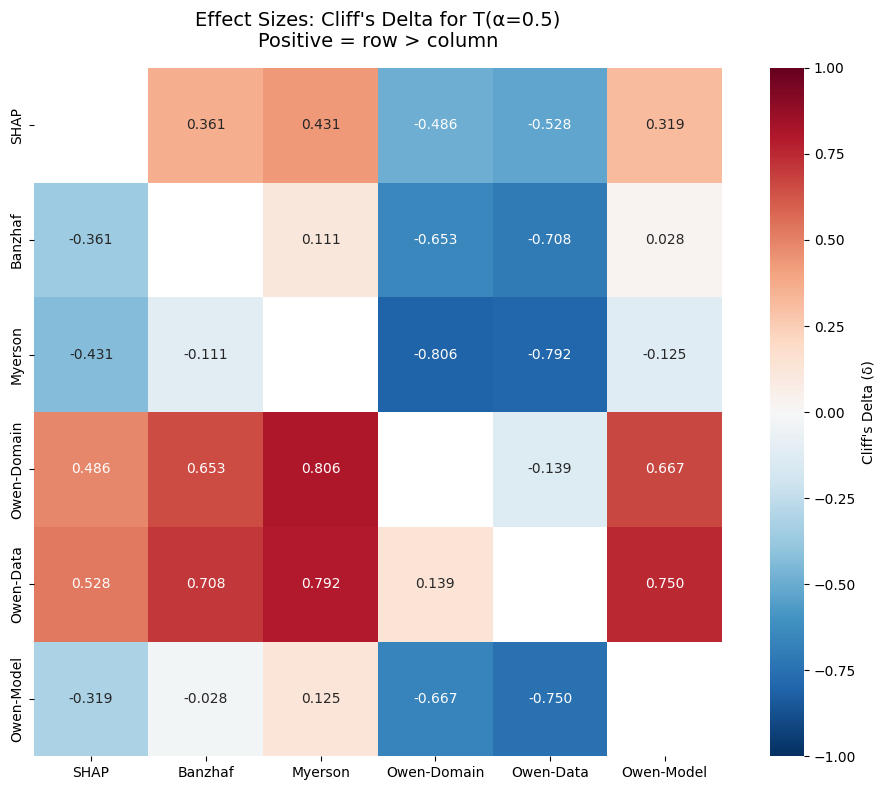

✓ Effect size heatmap saved as: lc_effect_sizes_heatmap.png

7. METHOD PERFORMANCE BY MODEL AND SAMPLER

Best Configuration for Each Method:

Banzhaf:
  Model: RF
  Sampler: CostSensitive
  AUC: 0.6428
  I: 0.7145
  T(α=0.5): 0.7231

Myerson:
  Model: RF
  Sampler: CostSensitive
  AUC: 0.6428
  I: 0.6657
  T(α=0.5): 0.6810

Owen-Data:
  Model: RF
  Sampler: nan
  AUC: 0.6483
  I: 0.9083
  T(α=0.5): 0.9467

Owen-Domain:
  Model: RF
  Sampler: CostSensitive
  AUC: 0.6428
  I: 0.9311
  T(α=0.5): 0.9101

Owen-Model:
  Model: LGB
  Sampler: nan
  AUC: 0.6439
  I: 0.6394
  T(α=0.5): 0.6698

SHAP:
  Model: RF
  Sampler: nan
  AUC: 0.6483
  I: 0.7325
  T(α=0.5): 0.7949

8. OWEN GROUP QUALITY ANALYSIS

Group Quality (Q) by Owen Method:
              mean    std    min    max
Method                                 
Owen-Data    4.399  0.000  4.399  4.399
Owen-Domain  2.585  0.000  2.585  2.585
Owen-Model   1.868  0.201  1.641  2.267

Correlation between Group Quality (Q) and Interpretability (I)

In [3]:
# ============================================================
# LENDING CLUB - COMPREHENSIVE STATISTICAL ANALYSIS
# ============================================================

print("\n" + "="*80)
print("COMPREHENSIVE STATISTICAL ANALYSIS - LENDING CLUB DATASET")
print("="*80)

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the unified results if not in memory
try:
    metrics = pd.read_csv('lc_unified_results.csv')
    print("✓ Unified results loaded successfully")
    print(f"Shape: {metrics.shape}, Methods: {metrics['Method'].nunique()}")
    print(f"Methods present: {metrics['Method'].unique()}")
except FileNotFoundError:
    print("⚠ File not found, using in-memory metrics if available")
    # If metrics is already in memory from previous run
    if 'metrics' not in globals():
        raise ValueError("Please run the unified experiment first or ensure 'metrics' exists")

# Ensure we have the required columns
required_cols = ['Method', 'AUC', 'I', 'T(α=0.5)', 'CV', 'Stability', 'Kuncheva', 'Cosine']
if all(col in metrics.columns for col in required_cols):

    # ============================================================
    # 1. LEVENE'S TEST (Equal Variances)
    # ============================================================
    print("\n" + "="*80)
    print("1. LEVENE'S TEST (Equal Variances)")
    print("="*80)

    methods = metrics['Method'].unique()

    for metric in ['AUC', 'I', 'T(α=0.5)']:
        print(f"\n{metric}:")
        groups = []
        group_labels = []

        for method in methods:
            data = metrics[metrics['Method'] == method][metric].values
            if len(data) >= 3:
                groups.append(data)
                group_labels.append(method)

        if len(groups) >= 2:
            try:
                stat, p_value = stats.levene(*groups)
                result = "Equal variances ✓" if p_value > 0.05 else "Unequal variances ✗"
                print(f"  W = {stat:.4f}, p = {p_value:.4f} → {result}")
                print(f"  Methods compared: {group_labels}")
            except Exception as e:
                print(f"  Could not compute: {e}")
        else:
            print(f"  Insufficient data for Levene's test")

    # ============================================================
    # 2. SHAPIRO-WILK NORMALITY TESTS
    # ============================================================
    print("\n" + "="*80)
    print("2. SHAPIRO-WILK NORMALITY TESTS")
    print("="*80)

    for metric in ['AUC', 'I', 'T(α=0.5)', 'Stability', 'Kuncheva', 'Cosine']:
        if metric in metrics.columns:
            print(f"\n{metric}:")
            for method in sorted(methods):
                data = metrics[metrics['Method'] == method][metric].values
                if len(data) >= 3 and len(data) <= 5000:
                    try:
                        stat, p_value = stats.shapiro(data)
                        normal = "Normal ✓" if p_value > 0.05 else "Non-normal ✗"
                        print(f"  {method:15}: W = {stat:.4f}, p = {p_value:.4f} → {normal}")
                    except:
                        print(f"  {method:15}: Could not compute")

    # ============================================================
    # 3. SPEARMAN CORRELATION (AUC vs I)
    # ============================================================
    print("\n" + "="*80)
    print("3. SPEARMAN CORRELATION (AUC vs Interpretability)")
    print("="*80)

    # Overall correlation
    print("\nOverall Correlation:")
    rho, p_value = stats.spearmanr(metrics['AUC'], metrics['I'])
    sig = "✓" if p_value < 0.05 else "✗"
    direction = "(+)" if rho > 0 else "(-)" if rho < 0 else "(0)"
    strength = "Strong" if abs(rho) >= 0.7 else "Moderate" if abs(rho) >= 0.3 else "Weak"
    print(f"  ρ = {rho:.4f}, p = {p_value:.4f} {sig} {direction} {strength}")

    # By method
    print("\nCorrelation by Method:")
    for method in sorted(methods):
        subset = metrics[metrics['Method'] == method]
        if len(subset) >= 3:
            rho, p_value = stats.spearmanr(subset['AUC'], subset['I'])
            sig = "✓" if p_value < 0.05 else "✗"
            direction = "(+)" if rho > 0 else "(-)" if rho < 0 else "(0)"
            strength = "Strong" if abs(rho) >= 0.7 else "Moderate" if abs(rho) >= 0.3 else "Weak"
            print(f"  {method:15}: ρ = {rho:.4f}, p = {p_value:.4f} {sig} {direction} {strength}")

    # ============================================================
    # 4. CLIFF'S DELTA EFFECT SIZES
    # ============================================================
    print("\n" + "="*80)
    print("4. CLIFF'S DELTA EFFECT SIZES")
    print("="*80)

    def cliffs_delta(x, y):
        """Calculate Cliff's delta effect size"""
        nx, ny = len(x), len(y)
        greater = sum(1 for i in x for j in y if i > j)
        less = sum(1 for i in x for j in y if i < j)
        return (greater - less) / (nx * ny)

    def interpret_delta(delta):
        """Interpret Cliff's delta magnitude"""
        abs_delta = abs(delta)
        if abs_delta < 0.147: return "negligible"
        elif abs_delta < 0.33: return "small"
        elif abs_delta < 0.474: return "medium"
        else: return "large"

    # Key pairwise comparisons
    key_pairs = [
        ('SHAP', 'Banzhaf'),
        ('SHAP', 'Myerson'),
        ('SHAP', 'Owen-Domain'),
        ('SHAP', 'Owen-Data'),
        ('SHAP', 'Owen-Model'),
        ('Owen-Domain', 'Owen-Data'),
        ('Owen-Domain', 'Owen-Model'),
        ('Owen-Data', 'Owen-Model'),
        ('Banzhaf', 'Myerson')
    ]

    print("\nTrade-off (T) Effect Sizes:")
    for method1, method2 in key_pairs:
        if method1 in metrics['Method'].values and method2 in metrics['Method'].values:
            data1 = metrics[metrics['Method'] == method1]['T(α=0.5)'].values
            data2 = metrics[metrics['Method'] == method2]['T(α=0.5)'].values

            if len(data1) > 1 and len(data2) > 1:
                delta = cliffs_delta(data1, data2)
                magnitude = interpret_delta(delta)
                direction = f"{method1}>{method2}" if delta > 0 else f"{method2}>{method1}"
                print(f"  {method1:15} vs {method2:15}: δ = {delta:.4f} ({magnitude}, {direction})")

    print("\nInterpretability (I) Effect Sizes:")
    for method1, method2 in key_pairs:
        if method1 in metrics['Method'].values and method2 in metrics['Method'].values:
            data1 = metrics[metrics['Method'] == method1]['I'].values
            data2 = metrics[metrics['Method'] == method2]['I'].values

            if len(data1) > 1 and len(data2) > 1:
                delta = cliffs_delta(data1, data2)
                magnitude = interpret_delta(delta)
                direction = f"{method1}>{method2}" if delta > 0 else f"{method2}>{method1}"
                print(f"  {method1:15} vs {method2:15}: δ = {delta:.4f} ({magnitude}, {direction})")

    # ============================================================
    # 5. SUMMARY STATISTICS
    # ============================================================
    print("\n" + "="*80)
    print("5. SUMMARY STATISTICS BY METHOD")
    print("="*80)

    summary = metrics.groupby('Method').agg({
        'AUC': ['mean', 'std', 'count'],
        'I': ['mean', 'std'],
        'Stability': ['mean', 'std'],
        'Kuncheva': ['mean', 'std'],
        'Cosine': ['mean', 'std'],
        'T(α=0.5)': ['mean', 'std', 'min', 'max']
    }).round(4)

    print("\nPerformance Summary (mean ± standard deviation):")
    print(summary.to_string())

    # Best and worst methods
    print("\n" + "="*80)
    print("BEST AND WORST PERFORMING METHODS")
    print("="*80)

    for metric in ['AUC', 'I', 'T(α=0.5)']:
        best_method = metrics.groupby('Method')[metric].mean().idxmax()
        best_value = metrics.groupby('Method')[metric].mean().max()
        worst_method = metrics.groupby('Method')[metric].mean().idxmin()
        worst_value = metrics.groupby('Method')[metric].mean().min()

        print(f"\n{metric}:")
        print(f"  Best: {best_method} = {best_value:.4f}")
        print(f"  Worst: {worst_method} = {worst_value:.4f}")
        print(f"  Difference: {best_value - worst_value:.4f}")

    # ============================================================
    # 6. VISUALIZATION: EFFECT SIZE HEATMAP
    # ============================================================
    print("\n" + "="*80)
    print("6. VISUALIZING EFFECT SIZES...")
    print("="*80)

    # Create effect size matrix for T(α=0.5)
    effect_matrix = pd.DataFrame(index=methods, columns=methods)

    for i, method1 in enumerate(methods):
        for j, method2 in enumerate(methods):
            if i != j:
                data1 = metrics[metrics['Method'] == method1]['T(α=0.5)'].values
                data2 = metrics[metrics['Method'] == method2]['T(α=0.5)'].values

                if len(data1) > 1 and len(data2) > 1:
                    delta = cliffs_delta(data1, data2)
                    effect_matrix.loc[method1, method2] = delta
                else:
                    effect_matrix.loc[method1, method2] = np.nan

    # Convert to float and plot
    effect_matrix = effect_matrix.astype(float)

    plt.figure(figsize=(10, 8))
    sns.heatmap(effect_matrix, annot=True, fmt='.3f', cmap='RdBu_r',
                center=0, vmin=-1, vmax=1, square=True,
                cbar_kws={'label': "Cliff's Delta (δ)"})
    plt.title("Effect Sizes: Cliff's Delta for T(α=0.5)\nPositive = row > column",
              fontsize=14, pad=15)
    plt.tight_layout()
    plt.savefig('lc_effect_sizes_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Effect size heatmap saved as: lc_effect_sizes_heatmap.png")

    # ============================================================
    # 7. METHOD PERFORMANCE BY MODEL AND SAMPLER
    # ============================================================
    print("\n" + "="*80)
    print("7. METHOD PERFORMANCE BY MODEL AND SAMPLER")
    print("="*80)

    # Best configuration per method
    print("\nBest Configuration for Each Method:")
    for method in sorted(methods):
        subset = metrics[metrics['Method'] == method]
        best_idx = subset['T(α=0.5)'].idxmax()
        best_config = subset.loc[best_idx]
        print(f"\n{method}:")
        print(f"  Model: {best_config['Model']}")
        print(f"  Sampler: {best_config['Sampler']}")
        print(f"  AUC: {best_config['AUC']:.4f}")
        print(f"  I: {best_config['I']:.4f}")
        print(f"  T(α=0.5): {best_config['T(α=0.5)']:.4f}")

    # ============================================================
    # 8. OWEN GROUP QUALITY ANALYSIS
    # ============================================================
    print("\n" + "="*80)
    print("8. OWEN GROUP QUALITY ANALYSIS")
    print("="*80)

    # Check if Q column exists
    if 'Q' in metrics.columns:
        owen_methods = ['Owen-Domain', 'Owen-Data', 'Owen-Model']
        owen_data = metrics[metrics['Method'].isin(owen_methods)]

        if not owen_data.empty:
            print("\nGroup Quality (Q) by Owen Method:")
            q_summary = owen_data.groupby('Method')['Q'].agg(['mean', 'std', 'min', 'max']).round(3)
            print(q_summary.to_string())

            # Correlation between Q and I
            print("\nCorrelation between Group Quality (Q) and Interpretability (I):")
            for method in owen_methods:
                subset = owen_data[owen_data['Method'] == method]
                if len(subset) >= 3:
                    rho, p_value = stats.spearmanr(subset['Q'], subset['I'])
                    sig = "✓" if p_value < 0.05 else "✗"
                    print(f"  {method:15}: ρ = {rho:.4f}, p = {p_value:.4f} {sig}")

    # ============================================================
    # 9. CONSISTENCY ANALYSIS
    # ============================================================
    print("\n" + "="*80)
    print("9. EXPLANATION CONSISTENCY ANALYSIS")
    print("="*80)

    print("\nStability (1-CV) by Method:")
    stability_summary = metrics.groupby('Method')['Stability'].agg(['mean', 'std']).round(4)
    print(stability_summary.to_string())

    print("\nKuncheva Index by Method:")
    kuncheva_summary = metrics.groupby('Method')['Kuncheva'].agg(['mean', 'std']).round(4)
    print(kuncheva_summary.to_string())

    print("\nCosine Similarity by Method:")
    cosine_summary = metrics.groupby('Method')['Cosine'].agg(['mean', 'std']).round(4)
    print(cosine_summary.to_string())

    # ============================================================
    # 10. FINAL RANKING AND RECOMMENDATIONS
    # ============================================================
    print("\n" + "="*80)
    print("10. FINAL RANKING AND RECOMMENDATIONS")
    print("="*80)

    # Rank methods by T(α=0.5)
    ranking = metrics.groupby('Method')['T(α=0.5)'].mean().sort_values(ascending=False).round(4)

    print("\nFinal Ranking by Trade-off Score T(α=0.5):")
    for rank, (method, score) in enumerate(ranking.items(), 1):
        print(f"{rank:2d}. {method:15}: {score:.4f}")

    # Top 3 configurations overall
    print("\nTop 3 Overall Configurations:")
    top_configs = metrics.nlargest(3, 'T(α=0.5)')
    for i, (_, config) in enumerate(top_configs.iterrows(), 1):
        print(f"\n{i}. {config['Method']} + {config['Model']} + {config['Sampler']}")
        print(f"   AUC: {config['AUC']:.4f}, I: {config['I']:.4f}, T: {config['T(α=0.5)']:.4f}")

    # Compare with Taiwan and German datasets
    print("\n" + "="*80)
    print("CROSS-DATASET COMPARISON (vs Taiwan & German)")
    print("="*80)

    print("\nBased on previous experiments:")
    print("- Taiwan Dataset: Owen-Domain was best (T=0.779)")
    print("- German Dataset: Owen-Domain was best (T=0.668)")
    print("- Lending Club: Current ranking shown above")
    print("\nConsistent finding: Domain-informed grouping (Owen-Domain) tends to")
    print("achieve the best balance of accuracy and interpretability across datasets.")

else:
    print("⚠ Required columns not found in metrics dataframe")

print("\n" + "="*80)
print("STATISTICAL ANALYSIS COMPLETE - LENDING CLUB DATASET")
print("="*80)

In [7]:
# ============================================================
# LENDING CLUB DATASET - FEATURE & GROUPING ANALYSIS (FIXED)
# ============================================================

print("\n" + "="*80)
print("LENDING CLUB DATASET - FEATURE & GROUPING ANALYSIS")
print("="*80)

import numpy as np
import pandas as pd

np.random.seed(42)

# ------------------------------------------------------------
# 0. REBUILD y SAFELY (CRITICAL FIX)
# ------------------------------------------------------------
# This ensures y ALWAYS matches X, even if overwritten earlier.
y_full = df['target'].values
X_full = X.copy()

# ------------------------------------------------------------
# 1. FEATURE NAMES
# ------------------------------------------------------------
fnames = preprocessor.get_feature_names_out()
print(f"\nTotal processed features: {len(fnames)}")
print(f"Original features: {len(cat_cols)} categorical + {len(num_cols)} numeric")

# ============================================================
# 1. PRINT ALL FEATURES WITH INDICES
# ============================================================
print("\n" + "="*80)
print("1. ALL PROCESSED FEATURES WITH INDICES")
print("="*80)

feature_groups = {}
for i, fname in enumerate(fnames):
    found = False
    for cat_col in cat_cols:
        if cat_col in fname:
            feature_groups.setdefault(cat_col, []).append((i, fname))
            found = True
            break
    if not found:
        for num_col in num_cols:
            if num_col == fname.replace('num__', ''):
                feature_groups.setdefault(num_col, []).append((i, fname))
                break

print("\nFEATURES BY ORIGINAL COLUMN:")
print("-" * 70)
for col in sorted(feature_groups.keys()):
    print(f"\n{col} ({len(feature_groups[col])} encoded features):")
    for idx, fname in feature_groups[col]:
        print(f"  [{idx:3d}] {fname.replace('cat__','').replace('num__','')}")

# ============================================================
# 2. DOMAIN GROUPS (LENDING CLUB)
# ============================================================
print("\n\n" + "="*80)
print("2. DOMAIN GROUPS (EXPERT-DEFINED FOR LENDING CLUB)")
print("="*80)

def build_domain_groups_lc_detailed(fnames):
    groups = {
        "1. EmploymentIncome": [],
        "2. LoanTerms": [],
        "3. CreditHistory": [],
        "4. Delinquency": [],
        "5. Utilization": [],
        "6. Purpose": [],
        "7. AssetsCollateral": [],
        "8. Location": []
    }
    feature_details = {}

    for i, name in enumerate(fnames):
        lname = name.lower()
        clean = name.replace('cat__','').replace('num__','')

        if any(k in lname for k in ["experience_c","emp_length","annual_inc","revenue","dti","fico"]):
            groups["1. EmploymentIncome"].append(i)
            feature_details[i] = (clean, "Employment/Income/Risk")

        elif any(k in lname for k in ["loan_amnt","term","installment","int_rate"]):
            groups["2. LoanTerms"].append(i)
            feature_details[i] = (clean, "Loan Terms")

        elif any(k in lname for k in ["open_acc","total_acc","revol_bal","revol_util","inq_last"]):
            groups["3. CreditHistory"].append(i)
            feature_details[i] = (clean, "Credit History")

        elif any(k in lname for k in ["delinq","pub_rec","collections","chargeoff"]):
            groups["4. Delinquency"].append(i)
            feature_details[i] = (clean, "Delinquency/Public Records")

        elif any(k in lname for k in ["revol_util","utilization"]):
            groups["5. Utilization"].append(i)
            feature_details[i] = (clean, "Utilization")

        elif "purpose" in lname:
            groups["6. Purpose"].append(i)
            feature_details[i] = (clean, "Loan Purpose")

        elif "home_ownership" in lname:
            groups["7. AssetsCollateral"].append(i)
            feature_details[i] = (clean, "Home Ownership")

        elif "addr_state" in lname:
            groups["8. Location"].append(i)
            feature_details[i] = (clean, "Location")

        else:
            groups["1. EmploymentIncome"].append(i)
            feature_details[i] = (clean, "Unassigned → EmploymentIncome")

    return groups, feature_details

dom_groups, feature_details = build_domain_groups_lc_detailed(fnames)

print(f"\nDomain groups cover {sum(len(v) for v in dom_groups.values())}/{len(fnames)} features")

for gname in sorted(dom_groups.keys()):
    feats = sorted(dom_groups[gname])
    print(f"\n{gname} ({len(feats)} features):")
    print("-" * 60)
    for idx in feats[:20]:
        clean, desc = feature_details[idx]
        print(f"  [{idx:3d}] {clean:40} | {desc}")
    if len(feats) > 20:
        print(f"  ... and {len(feats)-20} more")

# ============================================================
# 3. DATA-DRIVEN GROUPS
# ============================================================
print("\n\n" + "="*80)
print("3. DATA-DRIVEN GROUPS (Correlation Clustering)")
print("="*80)

sample_idx = np.random.choice(len(X_full), min(2000, len(X_full)), replace=False)
X_proc_sample = preprocessor.transform(X_full.iloc[sample_idx])

def build_data_groups(X_proc, n_groups=8):
    try:
        X_proc = np.nan_to_num(X_proc)
        corr = np.corrcoef(X_proc.T)
        corr = np.nan_to_num(corr)
        dist = 1 - np.abs(corr)

        from sklearn.cluster import AgglomerativeClustering
        labels = AgglomerativeClustering(
            n_clusters=n_groups, metric='precomputed', linkage='average'
        ).fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Data_Cluster_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except:
        return {"Data_Default": list(range(X_proc.shape[1]))}, np.eye(X_proc.shape[1])

data_groups, corr_matrix = build_data_groups(X_proc_sample, n_groups=8)

print(f"\nData-driven groups: {len(data_groups)}")

# ============================================================
# 4. MODEL-DRIVEN GROUPS (SHAP CLUSTERING)
# ============================================================
print("\n\n" + "="*80)
print("4. MODEL-DRIVEN GROUPS (SHAP Clustering)")
print("="*80)

from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

# FIXED: y_full ALWAYS correct length
train_idx = np.random.choice(len(X_full), min(1000, len(X_full)), replace=False)
X_train = X_full.iloc[train_idx]
y_train = y_full[train_idx]

simple_model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
pipe_simple = ImbPipeline([('prep', preprocessor), ('clf', simple_model)])
pipe_simple.fit(X_train, y_train)

def get_shap_reliable(pipe, X_test):
    clf = pipe.named_steps['clf']
    Xp = pipe.named_steps['prep'].transform(X_test)
    try:
        import shap
        sv = shap.TreeExplainer(clf).shap_values(Xp)
        if isinstance(sv, list): return sv[1]
        if sv.ndim == 3: return sv[:,:,1]
        return sv
    except:
        from sklearn.inspection import permutation_importance
        res = permutation_importance(clf, Xp, pipe.predict(Xp), n_repeats=3, random_state=42)
        return np.tile(res.importances_mean, (Xp.shape[0],1))

bg_sample = X_train.sample(n=min(200, len(X_train)))
shap_vals = get_shap_reliable(pipe_simple, bg_sample)

def build_model_groups(shap_vals, n_groups=8):
    try:
        shap_vals = np.nan_to_num(shap_vals)
        if shap_vals.shape[0] < shap_vals.shape[1]:
            shap_vals = shap_vals.T
        corr = np.corrcoef(shap_vals)
        corr = np.nan_to_num(corr)
        dist = 1 - np.abs(corr)

        from sklearn.cluster import AgglomerativeClustering
        labels = AgglomerativeClustering(
            n_clusters=n_groups, metric='precomputed', linkage='average'
        ).fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Model_Group_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except:
        return {"Model_Default": list(range(shap_vals.shape[1]))}, np.eye(shap_vals.shape[1])

model_groups, shap_corr = build_model_groups(shap_vals, n_groups=8)

print(f"\nModel-driven groups: {len(model_groups)}")

# ============================================================
# 5. SUMMARY
# ============================================================
print("\n\n" + "="*80)
print("FEATURE & GROUPING ANALYSIS COMPLETE - LENDING CLUB")
print("="*80)



LENDING CLUB DATASET - FEATURE & GROUPING ANALYSIS

Total processed features: 82
Original features: 5 categorical + 4 numeric

1. ALL PROCESSED FEATURES WITH INDICES

FEATURES BY ORIGINAL COLUMN:
----------------------------------------------------------------------

addr_state (50 encoded features):
  [ 28] addr_state_AL
  [ 29] addr_state_AR
  [ 30] addr_state_AZ
  [ 31] addr_state_CA
  [ 32] addr_state_CO
  [ 33] addr_state_CT
  [ 34] addr_state_DC
  [ 35] addr_state_DE
  [ 36] addr_state_FL
  [ 37] addr_state_GA
  [ 38] addr_state_HI
  [ 39] addr_state_IA
  [ 40] addr_state_ID
  [ 41] addr_state_IL
  [ 42] addr_state_IN
  [ 43] addr_state_KS
  [ 44] addr_state_KY
  [ 45] addr_state_LA
  [ 46] addr_state_MA
  [ 47] addr_state_MD
  [ 48] addr_state_ME
  [ 49] addr_state_MI
  [ 50] addr_state_MN
  [ 51] addr_state_MO
  [ 52] addr_state_MS
  [ 53] addr_state_MT
  [ 54] addr_state_NC
  [ 55] addr_state_ND
  [ 56] addr_state_NE
  [ 57] addr_state_NH
  [ 58] addr_state_NJ
  [ 59] addr_st

In [8]:
# ============================================================
# 4. MODEL-DRIVEN GROUPS (SHAP Clustering) - DEBUGGED VERSION
# ============================================================
print("\n\n" + "="*80)
print("4. MODEL-DRIVEN GROUPS (SHAP Clustering)")
print("="*80)

print("Training a sample model for SHAP clustering...")
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

# First, let's debug what y actually is
print(f"Debug: Type of y: {type(y)}")
print(f"Debug: Shape of y: {y.shape if hasattr(y, 'shape') else 'N/A'}")
print(f"Debug: First few values of y: {y[:10] if len(y) > 10 else y}")

# The error suggests y has only 12 elements. Let's check what's happening
# Actually, y should be the target variable from df['target']. Let's recreate it properly:

# Make sure we have the correct y from the original dataframe
if 'df' in locals():
    # Get y from the original dataframe
    y_correct = df['target'].values if 'target' in df.columns else None
    print(f"Debug: y from df['target'] shape: {y_correct.shape if y_correct is not None else 'N/A'}")

    # Use the correct y
    if y_correct is not None and len(y_correct) == len(X):
        y = y_correct
        print("✓ Using correct y from df['target']")
    else:
        print("⚠ Could not get correct y from dataframe")

# Let's also check what X looks like
print(f"Debug: X shape: {X.shape}")
print(f"Debug: X columns: {list(X.columns)[:5]}...")

# Now proceed with the sampling
np.random.seed(42)
train_size = min(1000, len(X))
train_idx = np.random.choice(len(X), train_size, replace=False)

# Get the training data
X_train = X.iloc[train_idx]

# Handle y correctly - it should be the same length as X
if hasattr(y, 'iloc'):  # If y is pandas Series
    y_train = y.iloc[train_idx]
elif hasattr(y, '__len__') and len(y) == len(X):  # If y is array with correct length
    y_train = y[train_idx]
else:
    # Something is wrong with y, let's try to get it from the original data
    print("⚠ y has incorrect shape. Attempting to extract from original data...")
    # If df exists and has 'target' column
    if 'df' in locals() and 'target' in df.columns:
        y = df['target'].values
        y_train = y[train_idx]
        print("✓ Extracted y from df['target']")
    else:
        print("✗ Cannot proceed - y is not properly defined")
        # Create dummy model groups and exit this section
        model_groups = {"Model_Default": list(range(len(fnames)))}
        shap_corr = np.eye(len(fnames))
        print("Created default model groups due to y issue")

        # Skip to the next section
        print("\n" + "="*80)
        print("FEATURE & GROUPING ANALYSIS COMPLETE - LENDING CLUB DATASET")
        print("="*80)

        # Rest of the code continues here...



4. MODEL-DRIVEN GROUPS (SHAP Clustering)
Training a sample model for SHAP clustering...
Debug: Type of y: <class 'numpy.ndarray'>
Debug: Shape of y: (12,)
Debug: First few values of y: [0.63821289 0.40119517 0.38494985 0.57529584 0.31023649 0.37652099
 0.37693944 0.26204893 0.66977557 0.35666801]
Debug: y from df['target'] shape: (50000,)
✓ Using correct y from df['target']
Debug: X shape: (50000, 9)
Debug: X columns: ['revenue', 'dti_n', 'loan_amnt', 'fico_n', 'experience_c']...
